# Import and declaring certain arguments

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/CZ4045 Assignment 2/

/content/drive/MyDrive/CZ4045 Assignment 2


In [ ]:
# coding: utf-8
import argparse
import time
import math
import os
import torch
import torch.nn as nn
import torch.onnx
import data
import model
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:

class Args:
  data = './data/wikitext-2'
  model = 'FNNModel'
  emsize = 200
  context_size = 8
  nhid = 200
  nlayers = 2
  lr = 20
  clip = 0.25
  epochs = 40
  batch_size = 8
  bptt = 35
  dropout = 0.2
  tied = True
  seed = 1111
  cuda = True
  log_interval = 200
  save = 'model.pt'
  onnx_export = ''
  nhead = 2
  dry_run =  True

args=Args()

In [ ]:
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

device = torch.device("cuda" if args.cuda else "cpu")



# Load data

In [ ]:
###############################################################################
# Load data
###############################################################################

corpus = data.Corpus(args.data)

# Starting from sequential data, batchify arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.


In [ ]:
def batchify(data, bsz):
    value=[]
    data = data.numpy()
    for i,word in enumerate(data):
        if i+bsz>= len(data):
            # sentence boundary reached
            # ignoring sentence less than 3 words
            break
        # convert word to id
        value1 = []
        for j in range(bsz):
            value1.append(data[i+j])
        value.append(value1)
    value = torch.LongTensor(value)
    return value.to(device)

In [ ]:
# 8-gram language model

eval_batch_size = 8
train_data = batchify(corpus.train, args.context_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)

In [ ]:
torch.set_printoptions(edgeitems=100)
print(train_data)

tensor([[    0,     1,     2,     3,     4,     1,     0,     0],
        [    1,     2,     3,     4,     1,     0,     0,     5],
        [    2,     3,     4,     1,     0,     0,     5,     6],
        [    3,     4,     1,     0,     0,     5,     6,     2],
        [    4,     1,     0,     0,     5,     6,     2,     7],
        [    1,     0,     0,     5,     6,     2,     7,     8],
        [    0,     0,     5,     6,     2,     7,     8,     9],
        [    0,     5,     6,     2,     7,     8,     9,     3],
        [    5,     6,     2,     7,     8,     9,     3,    10],
        [    6,     2,     7,     8,     9,     3,    10,    11],
        [    2,     7,     8,     9,     3,    10,    11,     8],
        [    7,     8,     9,     3,    10,    11,     8,    12],
        [    8,     9,     3,    10,    11,     8,    12,    13],
        [    9,     3,    10,    11,     8,    12,    13,    14],
        [    3,    10,    11,     8,    12,    13,    14,    15],
        [ 

# Get data and labels

In [ ]:
# get the train and target for the train values
def get_batch(source, i):
    seq_len = min(args.bptt, len(source) - 1 - i)
    data = source[i:i+seq_len, 0:args.context_size]
    target = source[i+1:i+1+seq_len, args.context_size-1:args.context_size]
    target = target.narrow(1,0,1).contiguous().view(-1)
    return data, target

In [ ]:
data, target = get_batch(train_data, 0)

# Feed-forward Neural Network

In [ ]:
# New FNN class

class FNNModel(nn.Module):
    # Context_size is set to be 8 given that it is an 8-gram model. 
    # Embedding dimension is 200
    # Hidden is the number of hidden neurons
    
    def __init__(self, vocab_size, embedding_dim, context_size, hidden, tie_weights=False):
        super(FNNModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, hidden)
        # Linear 2 is the decoder that returns a variable based on vocab size 
        self.linear2 = nn.Linear(hidden, vocab_size, bias = False)

        #tie the embedding weigths and linear decoder together 
        if tie_weights:
          if hidden != embedding_dim:
              raise ValueError('When using the tied flag, nhid must be equal to emsize')
          self.linear2.weight = self.embeddings.weight

        #initiate the weights 
        self.init_weights()

    #Initiate weights 
    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.embeddings.weight, -initrange, initrange)
        nn.init.zeros_(self.linear2.weight)
        nn.init.uniform_(self.linear2.weight, -initrange, initrange)


    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # Apply tanh activation function
        out = torch.tanh(self.linear1(embeds))
        out = self.linear2(out)
        # The output layer is a softmax layer
        log_probs = torch.nn.functional.log_softmax(out, dim=1)
        # return log probabilities
        return log_probs

# Declare helper functions  

In [ ]:
# get accuracy from log probabilities
def get_accuracy(log_probs, labels):
    probs = torch.exp(log_probs)
    predicted_label = torch.argmax(probs, dim=1)
    acc = (predicted_label == labels).float().mean()
    return acc



# evaluate model
def evaluate(model, criterion, data_source):
    model.eval()
    
    avg_acc = 0
    avg_loss = 0
    count = 0

    with torch.no_grad():
        start_time = time.time()
        for idx, data_tensor in enumerate(range(0, data_source.size(0) - 1, args.bptt)):
            context, target = get_batch(data_source, data_tensor)
            context, target = context.to(device), target.to(device)
            log_probs = model(context)
            avg_loss += criterion(log_probs, target).item()
            avg_acc += get_accuracy(log_probs, target)
            count += 1
            if idx % 500 == 0: 
                print("Iteration {}. Average Loss: {}; Average Acc:{}; Time taken(s): {}".format(idx, avg_loss / count, avg_acc / count, (time.time()-start_time)))
                start_time = time.time()

    return avg_acc / count, avg_loss / count


# Training the model and evaluating on val set

In [ ]:
# Using negative log-likelihood loss
loss_function = nn.NLLLoss()

# create model
ntokens = len(corpus.dictionary)
model = FNNModel(ntokens, args.emsize, args.context_size, args.nhid).to(device)

# ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)

#define epochs
epochs = 15

best_acc = 0
# perplexity
best_ppl = float('inf')
best_model_path = None
#training set results 
training_loss=[]
training_ppl=[]
training_acc=[]

#val set results
val_loss = []
val_ppl=[]
val_acc=[]

for epoch in range(epochs):
    start_time = time.time()
    total_loss = 0.0
    total_ppl =0.0
    total_acc=0.0
    print("\n === Training model Epoch: {} ===".format(epoch+1))
    for idx, data_tensor in enumerate(range(0, train_data.size(0) - 1, args.bptt)):
        context_tensor, target_tensor= get_batch(train_data, data_tensor)
        context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)

        # clear the gradient
        model.zero_grad()

        # get log probabilities over next words
        log_probs = model(context_tensor)

        # calculate current accuracy
        acc = get_accuracy(log_probs, target_tensor)

        # compute loss function
        loss = loss_function(log_probs, target_tensor)

        # update gradient
        loss.backward()
        optimizer.step()
        
        # get total loss and perplexity
        total_loss = total_loss + loss.item()
        total_ppl = total_ppl + math.exp(loss.item())
        total_acc = total_acc+ acc


        if idx % 1000 == 0: 
            print("Iteration {} of epoch {}. Loss: {:.4f}; Acc:{:.4f}; Time taken: {:.4f} Ppl: {:.4f}".format(idx, epoch, loss.item(), acc, (time.time()-start_time),  math.exp(loss.item())))
            start_time = time.time()

    
    #Getting the total loss, perplexity and accuracy
    total_runs = math.floor((train_data.size(0) - 1)/(args.bptt))
    training_loss.append(total_loss / total_runs)
    training_ppl.append(total_ppl / total_runs)
    training_acc.append(total_acc/ total_runs)

    #Evaluating the model on validation data set
    print("\n=== Evaluate data ===")
    ev_acc, ev_loss = evaluate(model, loss_function, val_data)
    ev_ppl = math.exp(ev_loss)
    print("Epoch {} complete. Accuracy: {:.4f}; Loss: {:.4f};  Perplexity: {:.4f}".format(epoch, ev_acc, ev_loss, ev_ppl))
    val_acc.append(ev_acc)
    val_loss.append(ev_loss)
    val_ppl.append(ev_ppl)

    # saving the model with lowest perplexity
    if ev_ppl < best_ppl:
        print("Perplexity improved from {:.4f} to {:.4f}, saving model...".format(best_ppl, ev_ppl))
        best_ppl = ev_ppl
        with open(args.save, 'wb') as f:
            torch.save(model, f)
        # set best model path



 === Training model Epoch: 1 ===
Iteration 0 of epoch 0. Loss: 10.4115; Acc:0.0000; Time taken: 0.2228 Ppl: 33239.9137
Iteration 1000 of epoch 0. Loss: 6.0714; Acc:0.1143; Time taken: 12.0484 Ppl: 433.2884
Iteration 2000 of epoch 0. Loss: 6.8922; Acc:0.0857; Time taken: 11.9760 Ppl: 984.5247
Iteration 3000 of epoch 0. Loss: 6.0486; Acc:0.1429; Time taken: 11.9964 Ppl: 423.5335
Iteration 4000 of epoch 0. Loss: 6.7034; Acc:0.1143; Time taken: 11.9966 Ppl: 815.1343
Iteration 5000 of epoch 0. Loss: 6.4658; Acc:0.1429; Time taken: 11.9866 Ppl: 642.7773
Iteration 6000 of epoch 0. Loss: 5.2400; Acc:0.3429; Time taken: 11.9828 Ppl: 188.6652
Iteration 7000 of epoch 0. Loss: 6.9050; Acc:0.1143; Time taken: 12.0061 Ppl: 997.2606
Iteration 8000 of epoch 0. Loss: 6.6868; Acc:0.2000; Time taken: 11.9999 Ppl: 801.7797
Iteration 9000 of epoch 0. Loss: 4.8308; Acc:0.3429; Time taken: 12.0059 Ppl: 125.3077
Iteration 10000 of epoch 0. Loss: 5.8571; Acc:0.2571; Time taken: 12.0225 Ppl: 349.7155
Iteration

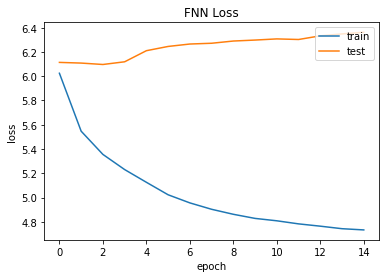

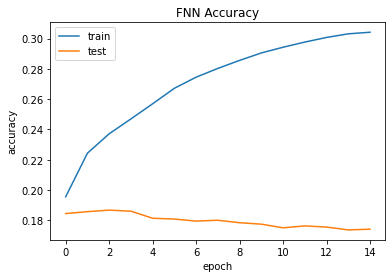

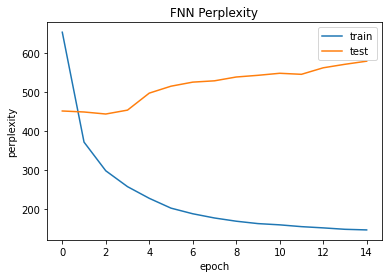

In [ ]:
plot1 = plt.figure(1)
plt.plot(training_loss)
plt.plot(val_loss)
plt.title('FNN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plot2 = plt.figure(2)
plt.plot(training_acc)
plt.plot(val_acc)
plt.title('FNN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plot3 = plt.figure(3)
plt.plot(training_ppl)
plt.plot(val_ppl)
plt.title('FNN Perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Evaluate on test set

In [ ]:
# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)

In [ ]:
test_acc, test_loss = evaluate(model, loss_function, test_data)
print('End of training. Test loss {:5.2f}, test ppl {:8.2f}, test acc {:5.2f}'.format(test_loss, math.exp(test_loss), test_acc))

Iteration 0. Average Loss: 5.389667510986328; Average Acc:0.17142857611179352; Time taken(s): 0.0041081905364990234
Iteration 500. Average Loss: 5.95644341352695; Average Acc:0.19281445443630219; Time taken(s): 0.8352360725402832
Iteration 1000. Average Loss: 5.98275388537587; Average Acc:0.19060921669006348; Time taken(s): 0.6900660991668701
Iteration 1500. Average Loss: 6.020731942960217; Average Acc:0.1882743537425995; Time taken(s): 0.708160400390625
Iteration 2000. Average Loss: 6.011430496933579; Average Acc:0.18689239025115967; Time taken(s): 0.7075073719024658
Iteration 2500. Average Loss: 6.006318724093462; Average Acc:0.18533167243003845; Time taken(s): 0.6910505294799805
Iteration 3000. Average Loss: 5.943872221467178; Average Acc:0.19126026332378387; Time taken(s): 0.7018067836761475
Iteration 3500. Average Loss: 5.993109706196571; Average Acc:0.18850968778133392; Time taken(s): 0.710207462310791
Iteration 4000. Average Loss: 5.980759187270271; Average Acc:0.189953222870826

# share the input  and output layer embeddings 

In [ ]:
# Using negative log-likelihood loss
loss_function = nn.NLLLoss()

# create model
ntokens = len(corpus.dictionary)
model = FNNModel(ntokens, args.emsize, args.context_size, args.emsize, True).to(device)

# ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)

#define epochs
epochs = 15

best_acc = 0
# perplexity
best_ppl = float('inf')
best_model_path = None
#training set results 
training_loss=[]
training_ppl=[]
training_acc=[]

#val set results
val_loss = []
val_ppl=[]
val_acc=[]

for epoch in range(epochs):
    start_time = time.time()
    total_loss = 0.0
    total_ppl =0.0
    total_acc=0.0
    print("\n === Training model Epoch: {} ===".format(epoch+1))
    for idx, data_tensor in enumerate(range(0, train_data.size(0) - 1, args.bptt)):
        context_tensor, target_tensor= get_batch(train_data, data_tensor)
        context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)

        # clear the gradient
        model.zero_grad()

        # get log probabilities over next words
        log_probs = model(context_tensor)

        # calculate current accuracy
        acc = get_accuracy(log_probs, target_tensor)

        # compute loss function
        loss = loss_function(log_probs, target_tensor)

        # update gradient
        loss.backward()
        optimizer.step()
        
        # get total loss and perplexity
        total_loss = total_loss + loss.item()
        total_ppl = total_ppl + math.exp(loss.item())
        total_acc = total_acc+ acc


        if idx % 1000 == 0: 
            print("Iteration {} of epoch {}. Loss: {:.4f}; Acc:{:.4f}; Time taken: {:.4f} Ppl: {:.4f}".format(idx, epoch, loss.item(), acc, (time.time()-start_time),  math.exp(loss.item())))
            start_time = time.time()
    
    #Getting the total loss, perplexity and accuracy
    total_runs = math.floor((train_data.size(0) - 1)/(args.bptt))
    training_loss.append(total_loss / total_runs)
    training_ppl.append(total_ppl / total_runs)
    training_acc.append(total_acc/ total_runs)

    #Evaluating the model on validation data set
    print("\n=== Evaluate data ===")
    ev_acc, ev_loss = evaluate(model, loss_function, val_data)
    ev_ppl = math.exp(ev_loss)
    print("Epoch {} complete. Accuracy: {:.4f}; Loss: {:.4f};  Perplexity: {:.4f}".format(epoch, ev_acc, ev_loss, ev_ppl))
    val_acc.append(ev_acc)
    val_loss.append(ev_loss)
    val_ppl.append(ev_ppl)

    # saving the model with lowest perplexity
    if ev_ppl < best_ppl:
        print("Perplexity improved from {:.4f} to {:.4f}, saving model...".format(best_ppl, ev_ppl))
        best_ppl = ev_ppl
        with open(args.save, 'wb') as f:
            torch.save(model, f)
        # set best model path




 === Training model Epoch: 1 ===
Iteration 0 of epoch 0. Loss: 10.4196; Acc:0.0000; Time taken: 0.2199 Ppl: 33509.8520
Iteration 1000 of epoch 0. Loss: 6.2069; Acc:0.0286; Time taken: 8.0173 Ppl: 496.1757
Iteration 2000 of epoch 0. Loss: 6.7727; Acc:0.0571; Time taken: 7.8957 Ppl: 873.6929
Iteration 3000 of epoch 0. Loss: 6.3627; Acc:0.0286; Time taken: 7.9071 Ppl: 579.7898
Iteration 4000 of epoch 0. Loss: 7.5543; Acc:0.0857; Time taken: 7.9179 Ppl: 1908.9842
Iteration 5000 of epoch 0. Loss: 6.5622; Acc:0.1143; Time taken: 7.8962 Ppl: 707.8181
Iteration 6000 of epoch 0. Loss: 5.4779; Acc:0.2000; Time taken: 7.9136 Ppl: 239.3549
Iteration 7000 of epoch 0. Loss: 6.7878; Acc:0.1143; Time taken: 7.9195 Ppl: 886.9397
Iteration 8000 of epoch 0. Loss: 7.1389; Acc:0.1714; Time taken: 7.9293 Ppl: 1260.0588
Iteration 9000 of epoch 0. Loss: 4.8464; Acc:0.3429; Time taken: 7.9263 Ppl: 127.2865
Iteration 10000 of epoch 0. Loss: 6.0100; Acc:0.2000; Time taken: 7.9352 Ppl: 407.4719
Iteration 11000 o

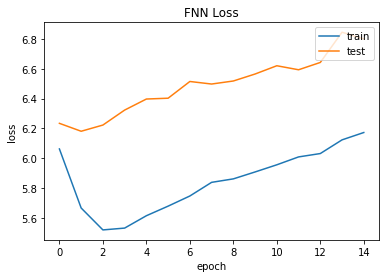

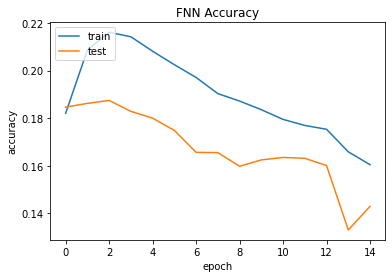

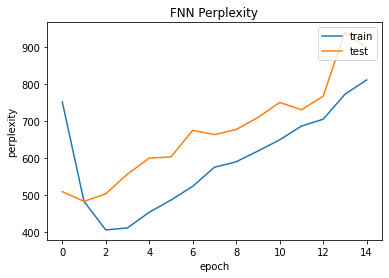

In [ ]:
plot4 = plt.figure(4)
plt.plot(training_loss)
plt.plot(val_loss)
plt.title('FNN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plot5 = plt.figure(5)
plt.plot(training_acc)
plt.plot(val_acc)
plt.title('FNN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plot6 = plt.figure(6)
plt.plot(training_ppl)
plt.plot(val_ppl)
plt.title('FNN Perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


# Evaluate on test set

In [ ]:
# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)

In [ ]:
test_acc, test_loss = evaluate(model, loss_function, test_data)
print('End of training. Test loss {:5.2f}, test ppl {:8.2f}, test acc {:5.2f}'.format(test_loss, math.exp(test_loss), test_acc))

Iteration 0. Average Loss: 5.404265403747559; Average Acc:0.20000000298023224; Time taken(s): 0.2181720733642578
Iteration 500. Average Loss: 6.069978931944766; Average Acc:0.18728260695934296; Time taken(s): 0.7853097915649414
Iteration 1000. Average Loss: 6.088802865692428; Average Acc:0.19003845751285553; Time taken(s): 0.6829380989074707
Iteration 1500. Average Loss: 6.109023813880499; Average Acc:0.18880735337734222; Time taken(s): 0.6866693496704102
Iteration 2000. Average Loss: 6.092175786701338; Average Acc:0.18747751414775848; Time taken(s): 0.6794695854187012
Iteration 2500. Average Loss: 6.076193530480417; Average Acc:0.18613116443157196; Time taken(s): 0.6878092288970947
Iteration 3000. Average Loss: 6.02346909542713; Average Acc:0.1896323561668396; Time taken(s): 0.6773264408111572
Iteration 3500. Average Loss: 6.065355178663575; Average Acc:0.1870734989643097; Time taken(s): 0.6703476905822754
Iteration 4000. Average Loss: 6.058812394794063; Average Acc:0.1881179660558700

# generate texts

In [ ]:
class Args:
  checkpoint = './model.pt'
  outf = 'generated.txt'
  words = 1000
  seed = 1111
  cuda =  True
  temperature = 1.0
  log_interval = 100

args=Args()

In [ ]:
with open(args.checkpoint, 'rb') as f:
    model = torch.load(f)
model.eval()

ntokens = len(corpus.dictionary)

input = torch.randint(ntokens, (1, 8), dtype=torch.long).to(device)
with open(args.outf, 'w', encoding='utf-8') as outf:
    with torch.no_grad():  # no tracking history
        for i in range(args.words):
            output = model(input)
            word_weights = output.squeeze().div(args.temperature).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]
            input.fill_(word_idx)

            word = corpus.dictionary.idx2word[word_idx]

            outf.write(word + ('\n' if i % 20 == 19 else ' '))

            if i % args.log_interval == 0:
                print('| Generated {}/{} words'.format(i, args.words))


| Generated 0/1000 words
| Generated 100/1000 words
| Generated 200/1000 words
| Generated 300/1000 words
| Generated 400/1000 words
| Generated 500/1000 words
| Generated 600/1000 words
| Generated 700/1000 words
| Generated 800/1000 words
| Generated 900/1000 words
